In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet101V2

In [2]:
# lets look at the filepath
path = r"C:\Users\Yong Ren\Documents\Jupyter\Chest CT-Scan\Data\train"
filedirectory = []
for files in os.listdir(path):
    filedirectorys = filedirectory.append(os.path.join(path,files))
filedirectory

['C:\\Users\\Yong Ren\\Documents\\Jupyter\\Chest CT-Scan\\Data\\train\\adenocarcinoma_left_lower_lobe_T2_N0_M0_Ib',
 'C:\\Users\\Yong Ren\\Documents\\Jupyter\\Chest CT-Scan\\Data\\train\\large_cell_carcinoma_left_hilum_T2_N2_M0_IIIa',
 'C:\\Users\\Yong Ren\\Documents\\Jupyter\\Chest CT-Scan\\Data\\train\\normal',
 'C:\\Users\\Yong Ren\\Documents\\Jupyter\\Chest CT-Scan\\Data\\train\\squamous_cell_carcinoma_left_hilum_T1_N2_M0_IIIa']

In [3]:
# File Directory for both the train and test
train_path = r"C:\\Users\\Yong Ren\\Documents\\Jupyter\\Chest CT-Scan\\Data\\train"
test_path = r"C:\\Users\\Yong Ren\\Documents\\Jupyter\\Chest CT-Scan\\Data\\test"

In [4]:
# given that the dataset is really small, data augementation will be a good option to improve the accruracy
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [5]:
# using ResNet101V2 as the base model 
baseModel = ResNet101V2(weights="imagenet", include_top=False,input_shape = (350,350,3))
for layer in baseModel.layers:
    layer.trainable = False

baseModel.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350, 350, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 356, 356, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 175, 175, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 177, 177, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [6]:
# creating the output layers that merges with the ResNet101v2
x = baseModel.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)

In [7]:
# merging the 2 model together as one
model = Model(inputs= baseModel.input , outputs = x)

In [8]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350, 350, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 356, 356, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 175, 175, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 177, 177, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [10]:
earlystop = EarlyStopping(patience=5)

In [11]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 15,
                    verbose = 1,
                    validation_data = test_generator,
                    validation_steps = 50,
                    callbacks = [earlystop])

Epoch 1/15
100/100 [==============================] - 166s 2s/step - loss: 58.6489 - acc: 0.5040 - val_loss: 26.7645 - val_acc: 0.5120
Epoch 2/15
100/100 [==============================] - 164s 2s/step - loss: 15.0445 - acc: 0.6406 - val_loss: 4.5506 - val_acc: 0.6240
Epoch 3/15
100/100 [==============================] - 164s 2s/step - loss: 3.0426 - acc: 0.6847 - val_loss: 1.3735 - val_acc: 0.7160
Epoch 4/15
100/100 [==============================] - 164s 2s/step - loss: 1.7409 - acc: 0.6667 - val_loss: 0.9106 - val_acc: 0.6200
Epoch 5/15
100/100 [==============================] - 163s 2s/step - loss: 1.0629 - acc: 0.6807 - val_loss: 0.9050 - val_acc: 0.6520
Epoch 6/15
100/100 [==============================] - 163s 2s/step - loss: 0.8807 - acc: 0.7229 - val_loss: 0.7656 - val_acc: 0.6440
Epoch 7/15
100/100 [==============================] - 164s 2s/step - loss: 0.9468 - acc: 0.6908 - val_loss: 0.9338 - val_acc: 0.5840
Epoch 8/15
100/100 [==============================] - 163s 2s/step

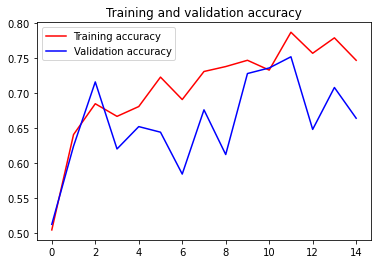

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()